In [2]:
import torch
import kagglehub
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm
from torchsummary import summary
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

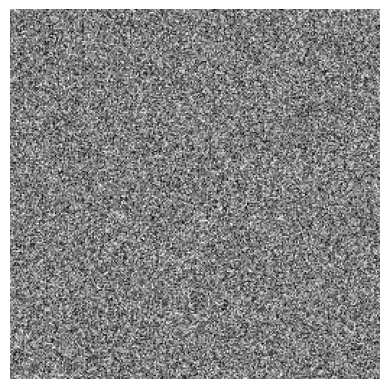

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def generate_image_from_mean_std(mean, std, image_size):
    # Generate a random image using a Gaussian distribution
    image = np.random.normal(loc=mean, scale=std, size=image_size)

    # Clip the values to be between 0 and 255 (to simulate valid pixel values for an 8-bit image)
    image = np.clip(image, 0, 255).astype(np.uint8)

    return image

# Define the parameters
mean = 128   # Mean pixel value (e.g., for grayscale images, it can be 128)
std = 50     # Standard deviation for pixel values
image_size = (256, 256)  # Size of the generated image (e.g., 256x256)

# Generate the image
image = generate_image_from_mean_std(mean, std, image_size)

# Display the image
plt.imshow(image, cmap='gray')
plt.axis('off')  # Turn off the axis
plt.show()


In [4]:
# Download latest version
data_dir = kagglehub.dataset_download("kritikseth/fruit-and-vegetable-image-recognition")

print("Path to dataset files:", data_dir)

Path to dataset files: /root/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8


In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [6]:
# Hyperparameters
batch_size = 256 + 128
img_size = 128  # original image size is 128x128
channels = 3
latent_dim = 64
B = 1000  # scaling factor for reconstruction loss
num_epochs = 10  # training epochs (this may take a while)

In [7]:
# Define transforms – note that transforms.ToTensor() scales pixels to [0,1]
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),  # Convert to RGB
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

In [8]:
# Load dataset using ImageFolder (expects subfolders per class)
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [9]:
# Split dataset into training (80%) and validation (20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

Training samples: 3060, Validation samples: 765


In [10]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [11]:
# Define the Variational Autoencoder (VAE) in PyTorch
class VAE(nn.Module):
    def __init__(self, channels, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        # Input: (3, 128, 128)
        self.conv1 = nn.Conv2d(channels, 16, kernel_size=3, padding=1)   # -> (16, 128, 128)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)  # -> (32, 64, 64)
        self.conv3 = nn.Conv2d(32, 128, kernel_size=3, padding=1)  # -> (128, 64, 64)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # -> (256, 64, 64)

        # Compute flattened dimension (256 channels * 64 * 64)
        self.flatten_dim = 256 * 64 * 64

        # Fully connected layers for latent variables
        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, self.flatten_dim)
        # After fc_decode, we reshape to (256, 64, 64)
        # Then use ConvTranspose2d layers to upscale back to (3, 128, 128)
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1)  # keeps (64,64)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)  # (64,64) -> (128,128)
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1)   # keeps (128,128)
        self.deconv4 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1)   # keeps (128,128)
        self.conv_final = nn.Conv2d(16, channels, kernel_size=3, padding=1)  # final layer -> (3, 128, 128)

    def encode(self, x):
        x = F.relu(self.conv1(x))       # (16,128,128)
        x = F.relu(self.conv2(x))       # (32,64,64)
        x = F.relu(self.conv3(x))       # (128,64,64)
        x = F.relu(self.conv4(x))       # (256,64,64)
        x = x.view(-1, self.flatten_dim)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = F.relu(self.fc_decode(z))
        x = x.view(-1, 256, 64, 64)
        x = F.relu(self.deconv1(x))  # (128,64,64)
        x = F.relu(self.deconv2(x))  # (64,128,128)
        x = F.relu(self.deconv3(x))  # (32,128,128)
        x = F.relu(self.deconv4(x))  # (16,128,128)
        x = torch.sigmoid(self.conv_final(x))  # (3,128,128) with pixel values in [0,1]
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [12]:
# Loss function for VAE: reconstruction (MSE) + KL divergence
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss: sum of squared errors over all pixels
    recon_loss = F.mse_loss(recon_x, x, reduction="none")
    recon_loss = recon_loss * B * 3 * 128 * 128  # scale up to match KL divergence
    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    recon_loss = torch.mean(recon_loss)
    vae_loss = torch.mean(recon_loss + kl_loss)
    kl_loss = torch.mean(kl_loss)
    return vae_loss, recon_loss, kl_loss

In [13]:
# Create model, optimizer, etc.
model = VAE(channels, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

In [14]:
# Print the summary of the model
summary(model, input_size=(channels, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
            Conv2d-2           [-1, 32, 64, 64]           4,640
            Conv2d-3          [-1, 128, 64, 64]          36,992
            Conv2d-4          [-1, 256, 64, 64]         295,168
            Linear-5                   [-1, 64]      67,108,928
            Linear-6                   [-1, 64]      67,108,928
            Linear-7              [-1, 1048576]      68,157,440
   ConvTranspose2d-8          [-1, 128, 64, 64]         295,040
   ConvTranspose2d-9         [-1, 64, 128, 128]          73,792
  ConvTranspose2d-10         [-1, 32, 128, 128]          18,464
  ConvTranspose2d-11         [-1, 16, 128, 128]           4,624
           Conv2d-12          [-1, 3, 128, 128]             435
Total params: 203,104,899
Trainable params: 203,104,899
Non-trainable params: 0
-----------------------

In [15]:
# Disable UserWarning
import warnings
warnings.filterwarnings("ignore")

In [16]:
model.train()
for epoch in range(num_epochs):
    train_loss = 0.0
    # Create a progress bar for the batches of the current epoch
    epoch_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for data, _ in epoch_bar:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, recon_loss, kl_loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        # Update the inner progress bar with the current loss
        epoch_bar.set_postfix(loss=loss.item())
    # Print epoch summary
    avg_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} Loss per sample: {avg_loss:.4f}  "
          f"Recon Loss: {recon_loss.item():.4f}  KL Loss: {kl_loss.item():.4f}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.50 GiB. GPU 0 has a total capacity of 14.74 GiB of which 832.12 MiB is free. Process 19883 has 13.93 GiB memory in use. Of the allocated memory 9.81 GiB is allocated by PyTorch, and 3.98 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# After training, visualize the reconstruction on validation images
model.eval()
with torch.no_grad():
    data_iter = iter(val_loader)
    images, _ = next(data_iter)
    images = images.to(device)
    recon_images, _, _ = model(images)

In [ ]:
# Plot original and reconstructed images side by side
n = 10  # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original image: (C,H,W) -> (H,W,C)
    orig = images[i].cpu().permute(1, 2, 0).numpy()
    recon = recon_images[i].cpu().permute(1, 2, 0).numpy()

    ax = plt.subplot(2, n, i + 1)
    plt.imshow(orig)
    plt.title("Original")
    plt.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon)
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()

In [ ]:
# Generate new images from random latent vectors
num_samples = 10
with torch.no_grad():
    z_random = torch.randn(num_samples, latent_dim).to(device)
    generated = model.decode(z_random)

In [ ]:
plt.figure(figsize=(20, 2))
for i in range(num_samples):
    gen = generated[i].cpu().permute(1, 2, 0).numpy()
    ax = plt.subplot(1, num_samples, i + 1)
    plt.imshow(gen)
    plt.axis('off')
plt.suptitle("Generated Images")
plt.show()